In [ ]:
!git clone https://github.com/hingma/Tlearn2rec.git

In [ ]:
%pip install torch torch_geometric pyomo networkx matplotlib wandb

In [ ]:
%cd ../..

In [ ]:
%cd Tlearn2rec/new/

# import

In [40]:
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

from torch_geometric.utils import to_undirected

from datasets import build_loaders, load_karate
from model import SimpleGCN, SimpleGAT, SimpleSAGE
from visualize import plot_embeddings_and_clusters, plot_network_clusters, plot_training_loss, plot_validation_loss, plot_karate_score
from cluster import GraphClustering, ClusteringEvaluator
#
import wandb


## Wandb config

In [28]:
# Configuration Parameters
import os
from pathlib import Path

# Base paths (scoped to project root)
PROJECT_ROOT = Path.cwd().resolve()
DATA_DIR = PROJECT_ROOT / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
RESULTS_DIR = PROJECT_ROOT / 'results'

# Default dataset/problem
# PROBLEM = 'facilities'
PROBLEM = 'osif'

# Data splits: directories already exist under data/processed/<problem>/{train,valid,test}
TRAIN_DIR = PROCESSED_DIR / PROBLEM / 'train'
VALID_DIR = PROCESSED_DIR / PROBLEM / 'valid'
TEST_DIR = PROCESSED_DIR / PROBLEM / 'test'

# Training hyperparameters
SEED = 42
BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
LR = 1e-3
MAX_EPOCHS = 200
PATIENCE = 10
EARLY_STOPPING = 20
TEMPERATURE = 0.1
NUM_WORKERS = min(8, os.cpu_count() or 2)

# Model hyperparameters (encoder dims)
EMBED_DIM = 64
HIDDEN_DIM = 64

# Output experiment directory
EXPERIMENT_DIR = MODELS_DIR / PROBLEM / 'UnsupervisedGNN'
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

# Debug/printing controls
DEBUG_SHAPES = True  # print tensor and layer shapes during the first steps


In [41]:
# Define hyperparameter configurations to try
project = f'MILP-GNN-{PROBLEM}'
hyperparameter_configs = [
    # {'architecture': 'SimpleGCN', 'learning_rate': 0.0075, 'batch_size': 16, 'epochs': 100, 'optimizer': 'adam'},
    # {'architecture': 'SimpleGCN', 'learning_rate': 0.0125, 'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'},
    {'architecture': 'SimpleGAT', 'learning_rate': 0.0075, 'batch_size': 16, 'epochs': 100, 'optimizer': 'adam'},
    {'architecture': 'SimpleGAT', 'learning_rate': 0.0125, 'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'},
    {'architecture': 'SimpleSAGE', 'learning_rate': 0.0075, 'batch_size': 16, 'epochs': 100, 'optimizer': 'adam'},
    {'architecture': 'SimpleSAGE', 'learning_rate': 0.0125, 'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'},
    ]
log_freq = 1
print_freq = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(f"{project}")

MILP-GNN-osif


# Loss function

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature: float = 0.1):
        super().__init__()
        self.temperature = temperature

    def forward(self, embeddings: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        row, col = edge_index
        pos = F.cosine_similarity(embeddings[row], embeddings[col], dim=1)
        pos = torch.exp(pos / self.temperature)

        num_nodes = embeddings.size(0)
        neg_idx = torch.randint(0, num_nodes, (row.numel(),), device=embeddings.device)
        neg = F.cosine_similarity(embeddings[col], embeddings[neg_idx], dim=1)
        neg = torch.exp(neg / self.temperature)

        loss = -torch.log(pos / (pos + neg + 1e-12)).mean()
        return loss


# Train for one epoch

In [42]:
def train_one_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module, optimizer: Optimizer, device: torch.device) -> float:
    model.train()
    total_loss = 0.0
    total_graphs = 0

    for i, data in enumerate(loader, 0):
        data = data.to(device)
        # Debug shapes
        if 'DEBUG_SHAPES'== False and not getattr(model, '_printed_train_batch', False):
            print(f"[train] batch x: {tuple(data.x.shape)} | edge_index: {tuple(data.edge_index.shape)}")
            if hasattr(data, 'batch') and data.batch is not None:
                print(f"[train] batch vector: {tuple(data.batch.shape)}")
            model._printed_train_batch = True
        #===============================================
        optimizer.zero_grad()
        embeddings = model(data)
        edge_index = to_undirected(data.edge_index)
        loss = criterion(embeddings, edge_index)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_graphs += 1
        # log into wandb
        if i % log_freq == log_freq - 1:
            wandb.log({'train_loss': loss.item()})

    return total_loss / max(1, total_graphs)

@torch.no_grad()
def eval_loss(model: nn.Module, loader: DataLoader, criterion: nn.Module, device: torch.device) -> float:
    model.eval()
    total_loss = 0.0
    total_graphs = 0
    for i, data in enumerate(loader,0):
        data = data.to(device)
        if getattr(config, 'DEBUG_SHAPES', False) and not getattr(model, '_printed_valid_batch', False):
            print(f"[valid] batch x: {tuple(data.x.shape)} | edge_index: {tuple(data.edge_index.shape)}")
            model._printed_valid_batch = True
        embeddings = model(data)
        loss = criterion(embeddings, to_undirected(data.edge_index))
        total_loss += loss.item()
        total_graphs += 1
        # log into wandb
        if i % log_freq == log_freq - 1:
            wandb.log({'valid_loss': loss.item()})
    return total_loss / max(1, total_graphs)

@torch.no_grad()
def eval_on_karate(model: nn.Module, device: torch.device) -> float:
    data = load_karate()
    data = data.to(device)
    # Ensure x has the expected feature dimension for the current model
    in_channels_expected = getattr(model, 'conv1').in_channels
    x = data.x
    if x is None:
        x = torch.eye(data.num_nodes, device=device)
    if x.size(-1) < in_channels_expected:
        # pad with zeros
        pad = in_channels_expected - x.size(-1)
        x = F.pad(x, (0, pad))
    elif x.size(-1) > in_channels_expected:
        # project with a fixed random matrix (deterministic by seed)
        torch.manual_seed(SEED)
        proj = torch.randn(x.size(-1), in_channels_expected, device=device)
        x = x @ proj
    data.x = x
    embeddings = model(data)
    # simple proxy: intra-edge cosine similarity mean (higher is better)
    row, col = data.edge_index
    sim = F.cosine_similarity(embeddings[row], embeddings[col], dim=1)
    # log into wandb
    wandb.log({'karate_score': sim.mean().item()})
    return sim.mean().item()

# Clustering Pipeline

In [ ]:
@torch.no_grad()
def run_clustering_pipeline(embedding: torch.Tensor,
                            n_clusters: int | None = None,
                            true_labels: torch.Tensor | None = None,
                            use_gpu: bool = False):
    """Mirror the notebook pipeline: compute embeddings, run 3 clustering methods, evaluate.

    Returns dict with embeddings, predicted labels per method, and evaluation metrics per method.
    """
    if n_clusters is None and true_labels is not None:
        unique = torch.unique(true_labels)
        n_clusters = int(unique.numel())
    if n_clusters is None:
        n_clusters = 2

    clusterer = GraphClustering(n_clusters=n_clusters, use_gpu=use_gpu)
    evaluator = ClusteringEvaluator()

    results_summary = {}
    clustering_results = {}

    # K-Means
    try:
        kmeans_labels, _ = clusterer.kmeans_clustering(embedding)
        kmeans_results = evaluator.evaluate_clustering(true_labels, kmeans_labels, embedding)
        # evaluator.print_results(kmeans_results, "K-Means")
        results_summary['K-Means'] = kmeans_results
        clustering_results['kmeans'] = kmeans_labels
    except Exception as e:
        print(f"[clustering] K-Means failed: {e}")

    # Spectral
    try:
        spectral_labels, _ = clusterer.spectral_clustering(embedding)
        spectral_results = evaluator.evaluate_clustering(true_labels, spectral_labels, embedding)
        # evaluator.print_results(spectral_results, "Spectral")
        results_summary['Spectral'] = spectral_results
        clustering_results['spectral'] = spectral_labels
    except Exception as e:
        print(f"[clustering] Spectral failed: {e}")

    # Hierarchical
    try:
        hierarchical_labels, _ = clusterer.hierarchical_clustering(embedding)
        hierarchical_results = evaluator.evaluate_clustering(true_labels, hierarchical_labels, embedding)
        # evaluator.print_results(hierarchical_results, "Hierarchical")
        results_summary['Hierarchical'] = hierarchical_results
        clustering_results['hierarchical'] = hierarchical_labels
    except Exception as e:
        print(f"[clustering] Hierarchical failed: {e}")

    return {
        'embeddings': embedding,
        'clustering_results': clustering_results,
        'evaluation_results': results_summary,
    }


@torch.no_grad()
def evaluate_clustering_on_loader(model: nn.Module,
                                  loader: DataLoader,
                                  device: torch.device) -> None:
    """Evaluate clustering quality per-graph in a (possibly batched) loader and print averages.

    - Uses true labels `y` when available to compute ARI/NMI; always computes internal metrics.
    - Number of clusters is inferred from true labels when available; otherwise defaults to 2.
    """
    model.eval()

    # Aggregators per method -> metric -> list of values
    agg: dict[str, dict[str, list[float]]] = {}

    for batch in loader:
        batch = batch.to(device)
        embeddings = model(batch)

        # Determine graph ids in this batch (PyG provides `batch` vector when multiple graphs)
        if hasattr(batch, 'batch') and batch.batch is not None:
            graph_ids = torch.unique(batch.batch).tolist()
        else:
            graph_ids = [None]

        for gid in graph_ids:
            if gid is None:
                node_mask = torch.ones(embeddings.size(0), dtype=torch.bool, device=device)
            else:
                node_mask = (batch.batch == gid)

            emb_g = embeddings[node_mask]
            y_g = batch.y[node_mask] if (hasattr(batch, 'y') and batch.y is not None) else None

            if emb_g.size(0) < 2:
                continue

            n_clusters = int(torch.unique(y_g).numel()) if y_g is not None else 2

            out = run_clustering_pipeline(embedding=emb_g,  # bypass model; we already have emb_g
                                          n_clusters=n_clusters,
                                          true_labels=y_g,
                                          use_gpu=device.type == 'cuda')

            # Collect metrics
            for method_name, metrics in out['evaluation_results'].items():
                if method_name not in agg:
                    agg[method_name] = {k: [] for k in metrics.keys()}
                for metric, value in metrics.items():
                    if isinstance(value, float):
                        agg[method_name][metric].append(value)

    # Print averages
    if not agg:
        print("[clustering] No metrics collected.")
        return

    print("\n=== Clustering evaluation (averaged over validation graphs) ===")
    for method_name, metrics in agg.items():
        print(f"\n-- {method_name} --")
        for metric, values in metrics.items():
            if len(values) == 0:
                continue
            mean_val = sum(values) / len(values)
            print(f"{metric}: {mean_val:.4f}")


# Main training pipeline

In [43]:
train_loader, valid_loader = build_loaders(train_batch_size=1, valid_batch_size=1)
# Infer in_channels from first training graph
sample = next(iter(train_loader))
in_channels = sample.x.size(-1)

if DEBUG_SHAPES == True:
    print(f"[setup] inferred in_channels from dataset: {in_channels}")
    print(f"[setup] sample x: {tuple(sample.x.shape)}, edge_index: {tuple(sample.edge_index.shape)}")
# ================================

[setup] inferred in_channels from dataset: 4
[setup] sample x: (288, 4), edge_index: (2, 768)


In [36]:
def run(params):
    print(project)
    # Extract parameters
    learning_rate = params.get('learning_rate', 0.01)
    architecture = params.get('architecture', 'SimpleGCN')
    batch_size = params.get('batch_size', 64)
    epochs = params.get('epochs', 5)
    momentum = params.get('momentum', 0.9)
    optimizer_name = params.get('optimizer', 'adam')
    # ================================
    torch.manual_seed(SEED)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # ======= init wandb
    wandb.init(project=project,
        config=params,
        reinit=True)  # Allow multiple runs in the same process)
    # ======= load data ================================
    train_loader, valid_loader = build_loaders(train_batch_size=batch_size, valid_batch_size=batch_size)
    # ======= initialize model =========================
    print("training{model.__class__.__name__}")
    if architecture == 'SimpleGCN':
        model = SimpleGCN(in_channels=in_channels, hidden_channels=HIDDEN_DIM, embedding_dim=EMBED_DIM).to(device)
    elif architecture == 'SimpleGAT':
        model = SimpleGAT(in_channels=in_channels, hidden_channels=HIDDEN_DIM, embedding_dim=EMBED_DIM).to(device)
    elif architecture == 'SimpleSAGE':
        model = SimpleSAGE(in_channels=in_channels, hidden_channels=HIDDEN_DIM, embedding_dim=EMBED_DIM).to(device)
    # ================================
    optimizer = Adam(model.parameters(), lr=LR)
    # ================================
    criterion = ContrastiveLoss(temperature=TEMPERATURE)
    # ================================
    best_val = float('inf')
    epochs_no_improve = 0
    best_path = EXPERIMENT_DIR / f'best_{architecture}_with_{batch_size}_and_{learning_rate}.pt'
    train_losses = []
    val_losses = []
    karate_scores = []
    for epoch in range(1, MAX_EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = eval_loss(model, valid_loader, criterion, device)
        karate_score = eval_on_karate(model, device)
        #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        karate_scores.append(karate_score)
        #
        print(f"Epoch {epoch:03d} | train {train_loss:.4f} | val {val_loss:.4f} | karate {karate_score:.4f}")
        #
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            epochs_no_improve = 0
            torch.save({'state_dict': model.state_dict(), 'in_channels': in_channels}, best_path)

    print(f"Best {model.__class__.__name__} model saved to: {best_path}")

    plot_training_loss(train_losses)
    plot_validation_loss(val_losses)
    plot_karate_score(karate_scores)

    # Finish the wandb run
    wandb.finish()

    # Clustering-based evaluation on validation set using ground-truth labels when available
    # evaluate_clustering_on_loader(model, valid_loader, device)


Running config 1 of 4
MILP-GNN-osif


karate_score,▂▂▂▁▁▂▆▇███▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█████▇▇▅▅▃▄▄▄▄▃▄▂▃▃▂▃▃▂▃▄▄▂▁▄▄▄▃▂▁▂▃▄▁▃▂
valid_loss,███████▇▃▄▄▁▄▃▃▃▃▃▄▃▃▃▃▁▁▃▃▃▁▁▁▄▄▄▄▃▁▃▃▄
karate_score,0.97075
train_loss,0.56167
valid_loss,0.62717


training{model.__class__.__name__}
Epoch 001 | train 0.7470 | val 0.6925 | karate 0.8939
Epoch 002 | train 0.6697 | val 0.6926 | karate 0.8945
Epoch 003 | train 0.6685 | val 0.6925 | karate 0.8881
Epoch 004 | train 0.6671 | val 0.6922 | karate 0.8820
Epoch 005 | train 0.6659 | val 0.6915 | karate 0.8789
Epoch 006 | train 0.6639 | val 0.6901 | karate 0.8867
Epoch 007 | train 0.6601 | val 0.6853 | karate 0.9104
Epoch 008 | train 0.6483 | val 0.6610 | karate 0.9449
Epoch 009 | train 0.6145 | val 0.6074 | karate 0.9639
Epoch 010 | train 0.6019 | val 0.6069 | karate 0.9682
Epoch 011 | train 0.5964 | val 0.6057 | karate 0.9685
Epoch 012 | train 0.5939 | val 0.6044 | karate 0.9667
Epoch 013 | train 0.5926 | val 0.6038 | karate 0.9640
Epoch 014 | train 0.5917 | val 0.6038 | karate 0.9616
Epoch 015 | train 0.5910 | val 0.6035 | karate 0.9595
Epoch 016 | train 0.5905 | val 0.6030 | karate 0.9582
Epoch 017 | train 0.5900 | val 0.6024 | karate 0.9570
Epoch 018 | train 0.5894 | val 0.6020 | karate 

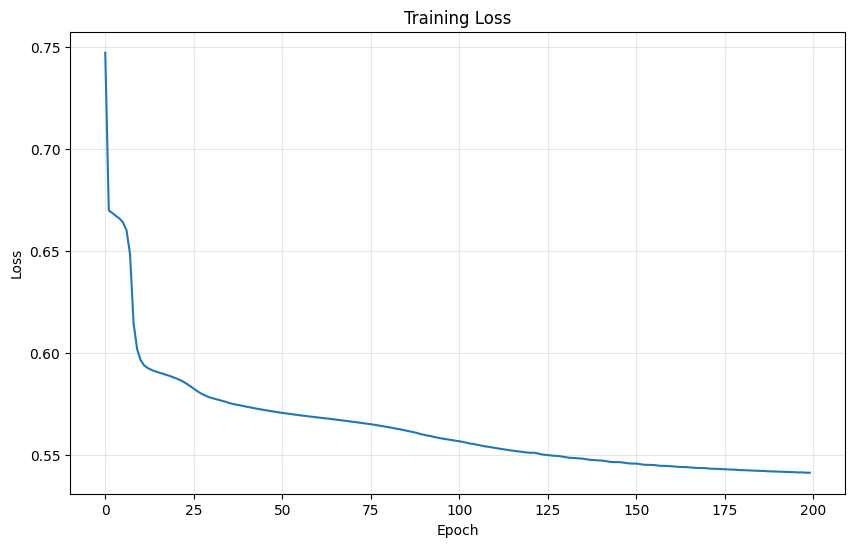

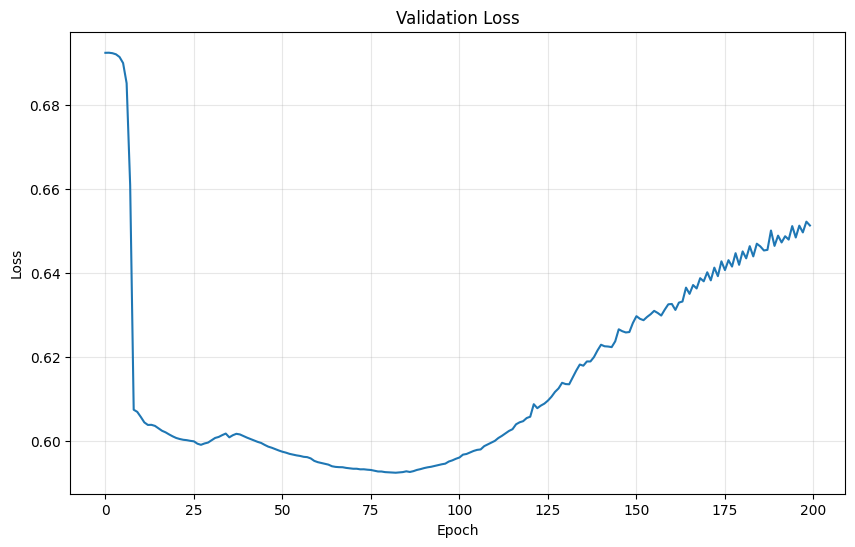

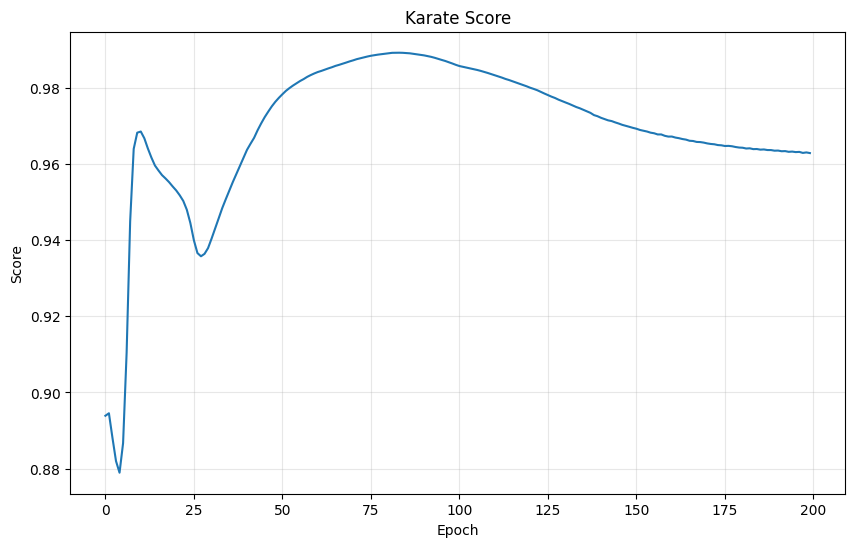

karate_score,▂▁▅▇▆▆▅▅▆▆▇██████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆
train_loss,█▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▂▂▁▂▁▂▁▁▂▁▁▂▂▂▁▁▁
valid_loss,██▅▂▂▄▂▅▃▅▁▃▄▁▃▁▅▅▅▄▃▁▃▂▆▆▄▄▆▂▆▆▆▃▆▄▄▆▆█
karate_score,0.9628
train_loss,0.52759
valid_loss,0.68499


Running config 2 of 4
MILP-GNN-osif


training{model.__class__.__name__}
Epoch 001 | train 0.8283 | val 0.6923 | karate 0.8872
Epoch 002 | train 0.6819 | val 0.6925 | karate 0.8969
Epoch 003 | train 0.6698 | val 0.6926 | karate 0.8985
Epoch 004 | train 0.6697 | val 0.6926 | karate 0.8955
Epoch 005 | train 0.6691 | val 0.6925 | karate 0.8920
Epoch 006 | train 0.6680 | val 0.6924 | karate 0.8889
Epoch 007 | train 0.6672 | val 0.6923 | karate 0.8863
Epoch 008 | train 0.6668 | val 0.6922 | karate 0.8842
Epoch 009 | train 0.6661 | val 0.6919 | karate 0.8833
Epoch 010 | train 0.6654 | val 0.6916 | karate 0.8850
Epoch 011 | train 0.6645 | val 0.6911 | karate 0.8892
Epoch 012 | train 0.6634 | val 0.6903 | karate 0.8964
Epoch 013 | train 0.6620 | val 0.6889 | karate 0.9071
Epoch 014 | train 0.6598 | val 0.6865 | karate 0.9204
Epoch 015 | train 0.6560 | val 0.6816 | karate 0.9343
Epoch 016 | train 0.6489 | val 0.6699 | karate 0.9482
Epoch 017 | train 0.6338 | val 0.6381 | karate 0.9604
Epoch 018 | train 0.6114 | val 0.5957 | karate 

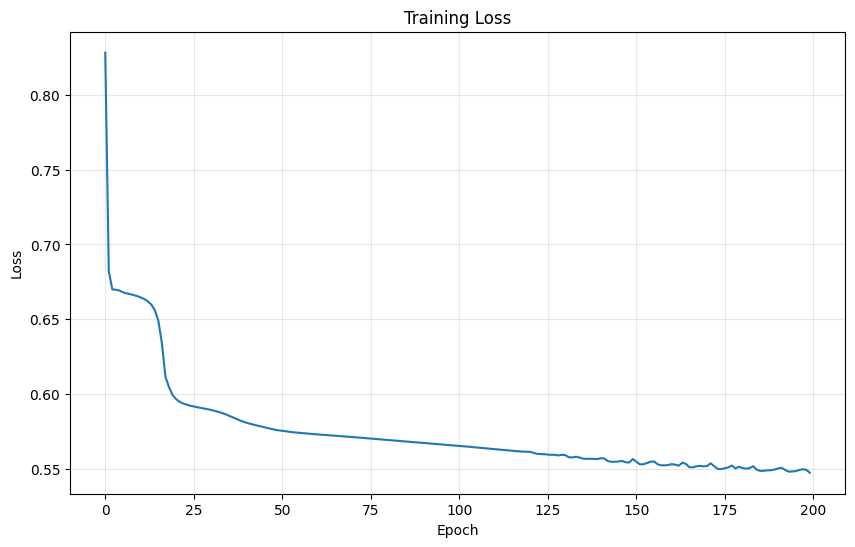

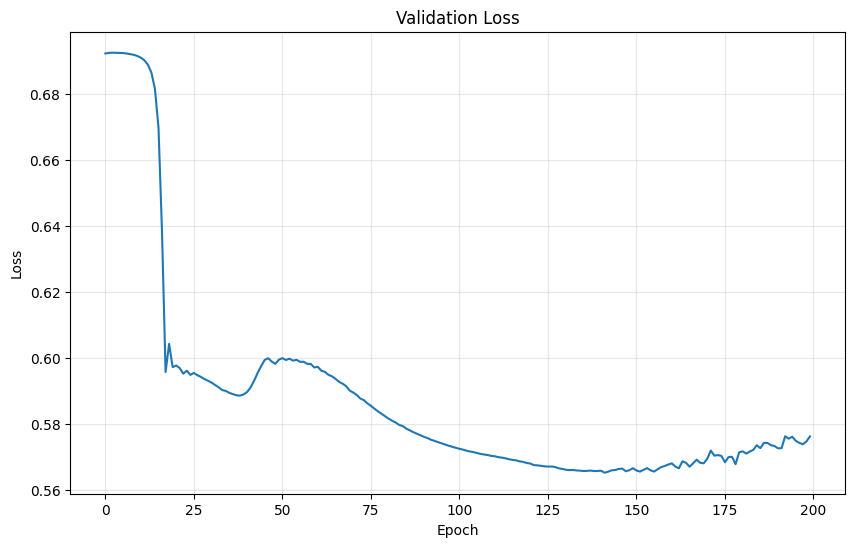

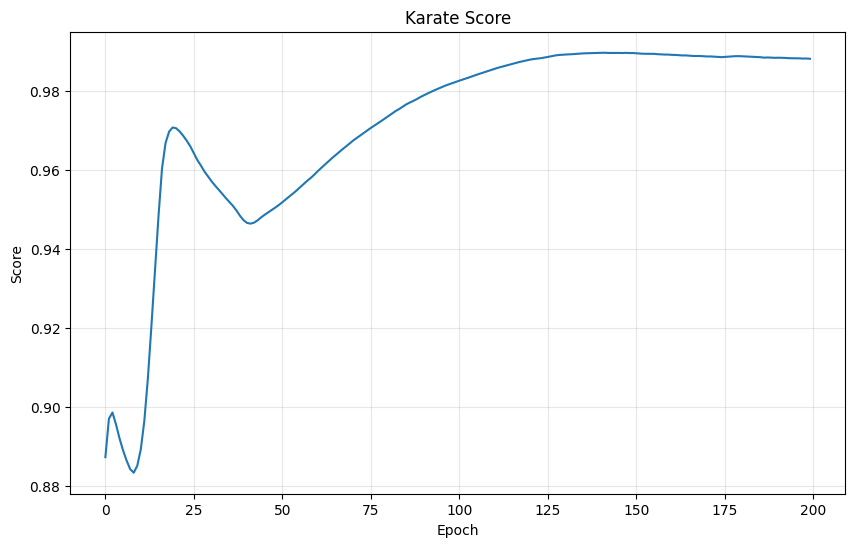

karate_score,▂▂▁▁▂▇▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████████
train_loss,██▇▄▄▄▄▃▃▄▃▄▃▃▃▃▂▂▂▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁
valid_loss,██▇▄▃▃▄▄▃▄▄▃▃▃▃▄▂▂▃▂▂▂▃▁▃▁▃▃▃▃▁▃▁▃▃▁▁▃▁▁
karate_score,0.98813
train_loss,0.55625
valid_loss,0.55619


Running config 3 of 4
MILP-GNN-osif


training{model.__class__.__name__}
Epoch 001 | train 0.6695 | val 0.6074 | karate 0.9461
Epoch 002 | train 0.5885 | val 0.5966 | karate 0.9553
Epoch 003 | train 0.5632 | val 0.5908 | karate 0.9553
Epoch 004 | train 0.5440 | val 0.5897 | karate 0.9527
Epoch 005 | train 0.5293 | val 0.5916 | karate 0.9547
Epoch 006 | train 0.5098 | val 0.5983 | karate 0.9510
Epoch 007 | train 0.4755 | val 0.6160 | karate 0.9426
Epoch 008 | train 0.4174 | val 0.6444 | karate 0.9330
Epoch 009 | train 0.3624 | val 0.6491 | karate 0.9305
Epoch 010 | train 0.3224 | val 0.6698 | karate 0.9318
Epoch 011 | train 0.2941 | val 0.6799 | karate 0.9328
Epoch 012 | train 0.2728 | val 0.6920 | karate 0.9341
Epoch 013 | train 0.2561 | val 0.7042 | karate 0.9376
Epoch 014 | train 0.2431 | val 0.7134 | karate 0.9410
Epoch 015 | train 0.2327 | val 0.7260 | karate 0.9433
Epoch 016 | train 0.2241 | val 0.7394 | karate 0.9460
Epoch 017 | train 0.2169 | val 0.7548 | karate 0.9481
Epoch 018 | train 0.2108 | val 0.7745 | karate 

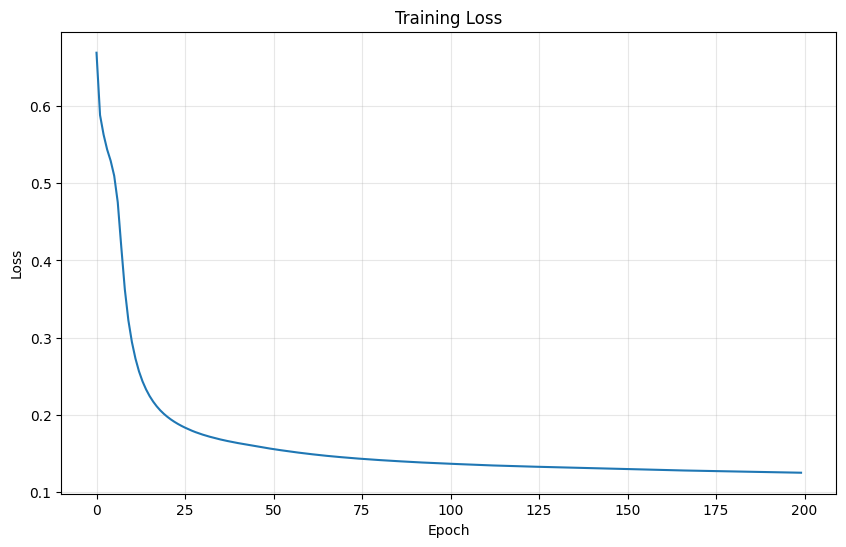

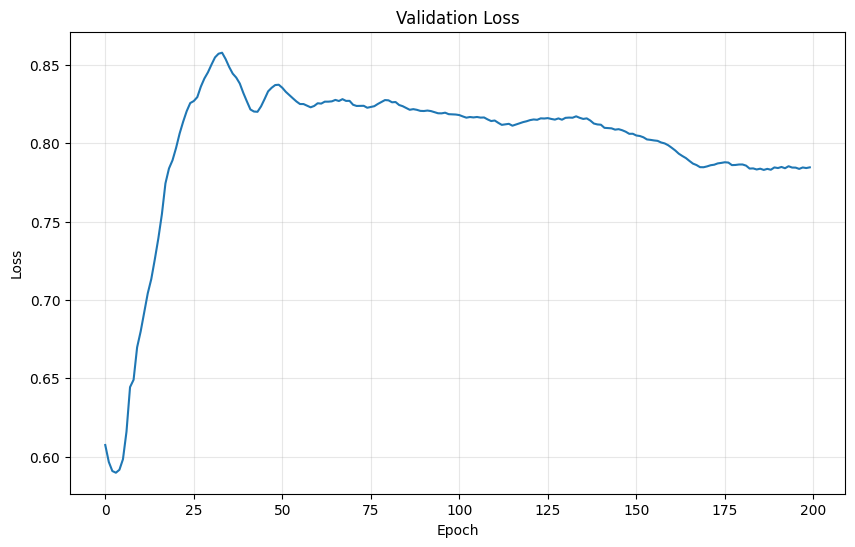

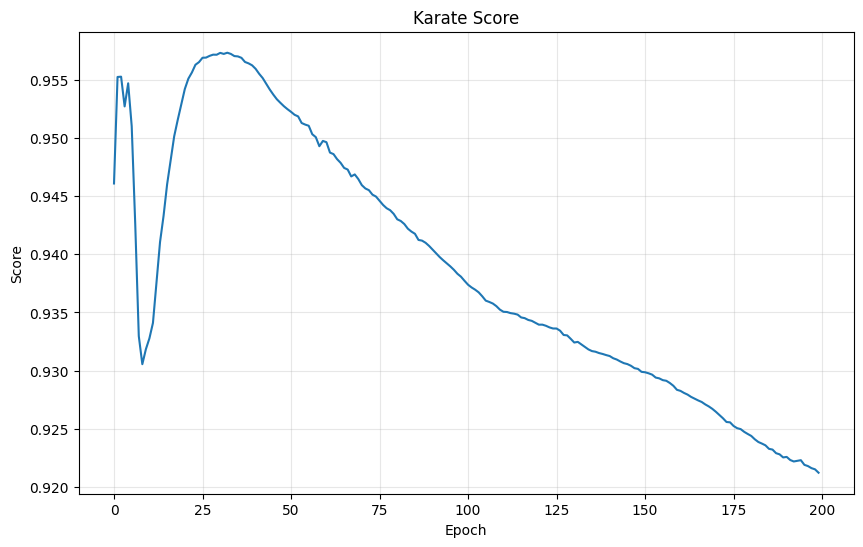

karate_score,▃▃▃▅▅▇███████▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▁
train_loss,█▆▆▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▃▁▂▂▇▅▅█▆▆█▇▅▆▅▅█▇▅▇▅▅▇▇▅█▅▅▇▆▅▆▅▆▄▇▇▅▆
karate_score,0.92121
train_loss,0.09777
valid_loss,0.85694


Running config 4 of 4
MILP-GNN-osif


training{model.__class__.__name__}
Epoch 001 | train 0.7218 | val 0.6170 | karate 0.9341
Epoch 002 | train 0.6182 | val 0.5969 | karate 0.9459
Epoch 003 | train 0.5946 | val 0.5906 | karate 0.9493
Epoch 004 | train 0.5801 | val 0.5830 | karate 0.9559
Epoch 005 | train 0.5673 | val 0.5767 | karate 0.9582
Epoch 006 | train 0.5558 | val 0.5734 | karate 0.9565
Epoch 007 | train 0.5464 | val 0.5717 | karate 0.9545
Epoch 008 | train 0.5386 | val 0.5714 | karate 0.9547
Epoch 009 | train 0.5310 | val 0.5722 | karate 0.9561
Epoch 010 | train 0.5223 | val 0.5739 | karate 0.9565
Epoch 011 | train 0.5110 | val 0.5762 | karate 0.9552
Epoch 012 | train 0.4953 | val 0.5806 | karate 0.9530
Epoch 013 | train 0.4738 | val 0.5889 | karate 0.9489
Epoch 014 | train 0.4433 | val 0.6033 | karate 0.9408
Epoch 015 | train 0.4066 | val 0.6253 | karate 0.9355
Epoch 016 | train 0.3745 | val 0.6172 | karate 0.9327
Epoch 017 | train 0.3474 | val 0.6304 | karate 0.9308
Epoch 018 | train 0.3249 | val 0.6634 | karate 

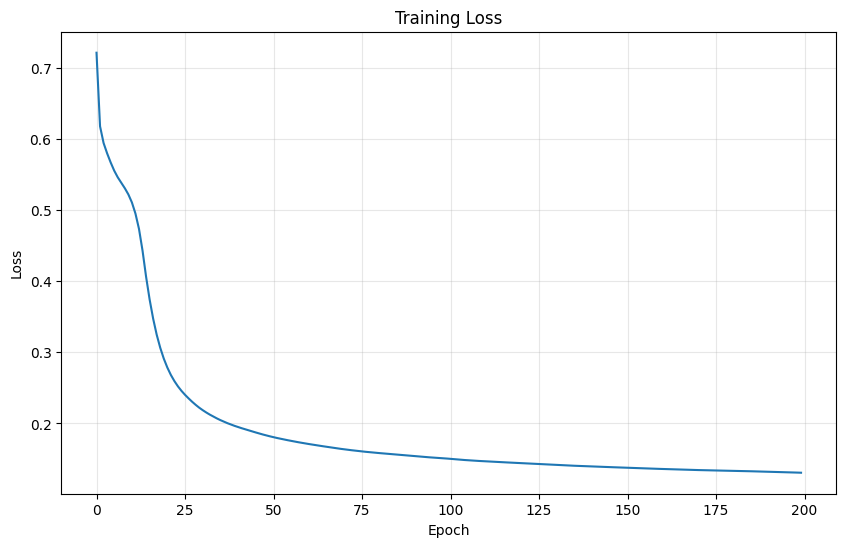

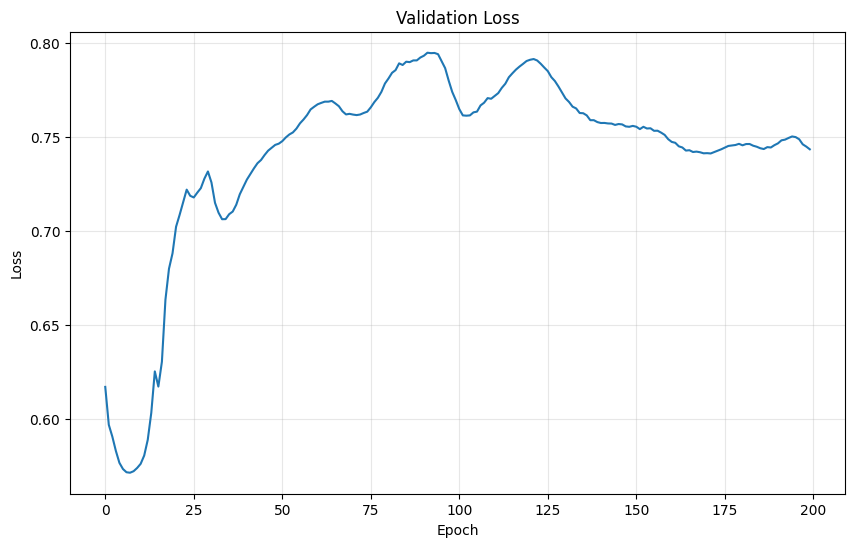

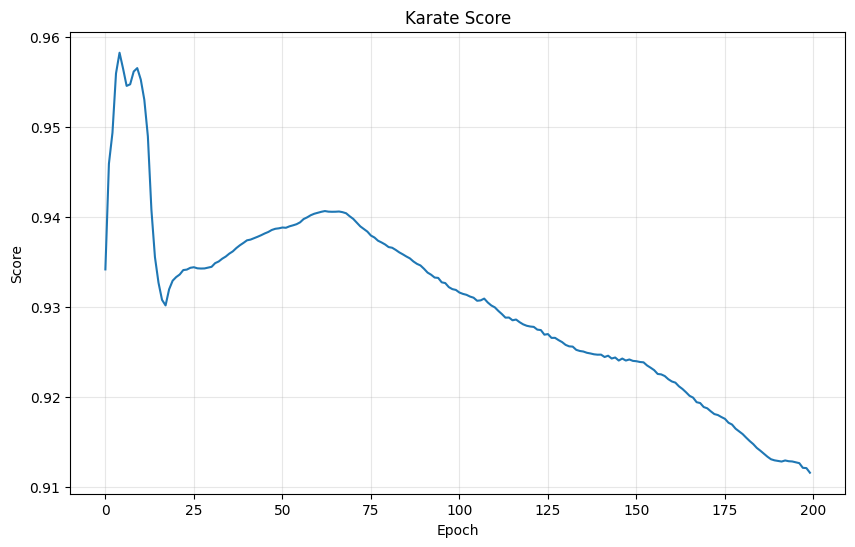

karate_score,▇███▄▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁
train_loss,█▆▆▆▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▃▁▄▆▄▆▆▆▅▆▄▄▅▅▅▇▅█▇▅▆█▇▅▅▅▅▇▅▄▄▄▆▅▅▅▅
karate_score,0.91155
train_loss,0.12423
valid_loss,0.71347


In [44]:
for i, config in enumerate(hyperparameter_configs):
    print(f"Running config {i+1} of {len(hyperparameter_configs)}")
    run(config)


In [ ]:
# torch.manual_seed(SEED)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_loader, valid_loader = build_loaders()

# # Infer in_channels from first training graph
# sample = next(iter(train_loader))
# in_channels = sample.x.size(-1)

# if getattr(config, 'DEBUG_SHAPES', False):
#     print(f"[setup] inferred in_channels from dataset: {in_channels}")
#     print(f"[setup] sample x: {tuple(sample.x.shape)}, edge_index: {tuple(sample.edge_index.shape)}")

# for model in [SimpleGCN, SimpleGAT, SimpleSAGE]:
#     print("training{model.__class__.__name__}")
#     model = model(in_channels=in_channels, hidden_channels=HIDDEN_DIM, embedding_dim=EMBED_DIM).to(device)
#     optimizer = Adam(model.parameters(), lr=LR)
#     criterion = ContrastiveLoss(temperature=TEMPERATURE)

#     best_val = float('inf')
#     epochs_no_improve = 0
#     best_path = EXPERIMENT_DIR / f'best_{model.__class__.__name__}.pt'
#     train_losses = []
#     val_losses = []
#     karate_scores = []
#     for epoch in range(1, MAX_EPOCHS + 1):
#         train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
#         val_loss = eval_loss(model, valid_loader, criterion, device)
#         karate_score = eval_on_karate(model, device)
#         #
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         karate_scores.append(karate_score)
#         #
#         print(f"Epoch {epoch:03d} | train {train_loss:.4f} | val {val_loss:.4f} | karate {karate_score:.4f}")
#         #
#         if val_loss < best_val - 1e-6:
#             best_val = val_loss
#             epochs_no_improve = 0
#             torch.save({'state_dict': model.state_dict(), 'in_channels': in_channels}, best_path)

#     print(f"Best {model.__class__.__name__} model saved to: {best_path}")

#     plot_training_loss(train_losses)
#     plot_validation_loss(val_losses)
#     plot_karate_score(karate_scores)

#     # Clustering-based evaluation on validation set using ground-truth labels when available
#     # evaluate_clustering_on_loader(model, valid_loader, device)
